Dear Readers,

In this article I am going to take you through a preliminary analysis of correlations in 4 different flavours, progressively increasing in mindf**ks. I discuss their important's and difference's with respect to two famously correlated pairs. Gold and Silver.

Gold and Silver are two precious metals as I'm sure you know. In that they tend to move closely together based on history. This is because they are used as a hedge for inflation (store of value), within technology (electronic components, batteries, etc) and also as a flight to safety from a fragile monetary system (see Rome). Both these metals have been used for thousands of years and throughout time have shown a core fundamental process to which they move together...more on this later...

For now we focus on correlations. Namely what is it, why it is important and how we can use correlations between assets to design trading strategies from. Although I won't be directly covering that in my articles since ideas are cheap but implemenation is $. 

Sample correlation follows a simple formula;
rho = covar(x,y)/sig(x)sig(y)

That is correlation (rho) between two assets x and y is the covariance between x and y divided by the standard deviation of x and y multiplied together. It measures the relationship to which two assets covariate with respect to their own independent standard deviation. Correlations therefore are bounded between [-1, 1] displaying negative and positive perfect correlations at the lower and upper bounds. Note, correlation is merely a metric used to define pure movements between prices. It is instantaneous and does not reflect a true underlying relationship. For keen readers this is known as causality which will lead into cointegration covered in part 2.

In this article we cover 4 types of correlation estimation procedures. First the stationary constant correlation this being the the spearmans rank and pearson correlation formula. Next a rolling correlation with variable window size. Thirdly a DCC model extracted from a GARCH model (for more reading please see the following papers; ). Finally we cover a unique case of stochastic correlation within an Ornstein-Uhlenbeck process.

All code is written by the author and is open-source. Feel free to download the files and have a go yourself. This article is all for education and sharing of ideas, if you have any notes or suggestions please feel free to contact me at the following email address: ....





To being, let's read in our data set. This data was extracted from Yahoo Finance then cleaned to make it "acceptable" for python dataframes.

We parse in the dataset using pandas, set parse_dates = True so python knows this is a datetime and index on this column.

In addition it is apt to understand the ETF's which we are analysing. The GLD and SLV are ETFs on silver and gold. They have their quirks and the KID can be found in the following links;

GLD:

SLV:

Therefore they are not trading physical but infact a "paper" version of this. We won't be going into what this means for the actual market of silver and gold but it's important to note here.

In [131]:
import pandas as pd
df = pd.read_csv("../Pdata/commodity_close_prices", parse_dates = True, index_col = 0)
print(df)

                 CPER         USO        SLV         GLD
Date                                                    
2011-11-15  25.180000  307.440002  33.660000  173.360001
2011-11-16  25.190001  314.720001  32.820000  171.509995
2011-11-17  25.190001  305.839996  30.639999  167.100006
2011-11-18  24.430000  302.559998  31.400000  167.619995
2011-11-21  23.690001  300.720001  30.760000  163.500000
...               ...         ...        ...         ...
2020-12-24  22.010000   32.919998  23.959999  176.350006
2020-12-28  22.190001   32.590000  24.430000  175.710007
2020-12-29  21.980000   32.779999  24.389999  176.350006
2020-12-30  21.950001   32.910000  24.760000  177.699997
2020-12-31  21.730000   33.009998  24.570000  178.360001

[2297 rows x 4 columns]


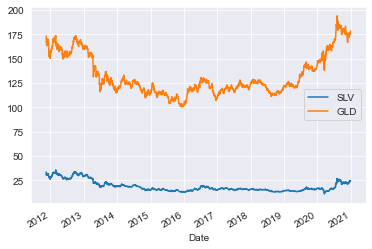

In [132]:
slv_gld = df[['SLV', 'GLD']]
slv_gld.plot()

Not too informative right? We cant even begin to understand the data with this difference in price. Let's reindex at 100 and review the time series

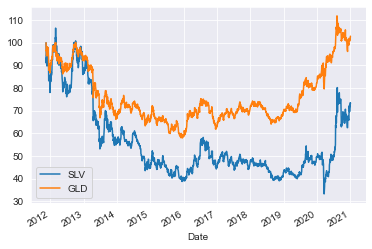

In [133]:
slv_gld = df[['SLV', 'GLD']]
first_row = slv_gld.iloc[0,:]
df_re_index = (slv_gld/first_row)*100
df_re_index.plot()
plt.legend()
plt.show()

Now thats better. From the reindexed graph starting on 2011-11-15 we can see that the two price series follow similar peak to trough with a noticeable dislocation occuring in Mar'20...something happened then...must've been on the news...something about 'Gina'?

Just to make sure lets also plot the GLD to SLV ratio.

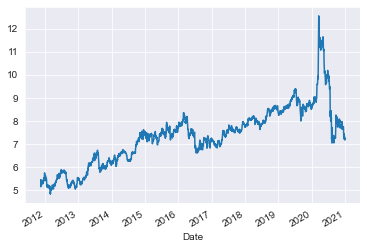

In [140]:
ratio = df['GLD']/df['SLV']
ratio.plot()

### CORRELATION EXTRACTION ###

We attempt 4 approaches

- Static Correlations

- Rolling Correlations

- DCC - GARCH(1,1) as in (paper)

- Stochastic correlation under the OU process as is Teng, Ehrhardt and Gunther (2016)

For the purposes of cross-examination we deal with just SLV and GLD to start    



Note: this applies the correlation over the entire window of the observed data

In [134]:
from scipy.stats import pearsonr
corr_p, _ = pearsonr(df.SLV, df.GLD)
print('Pearsons correlation: %.3f' % corr_p)

Pearsons correlation: nan


In [135]:
from scipy.stats import spearmanr
corr_s, _ = spearmanr(df.SLV, df.GLD)
print('Spearman correlation: %.3f' % corr_s)

Spearman correlation: 0.713


Now we examine rolling correlations and plot them

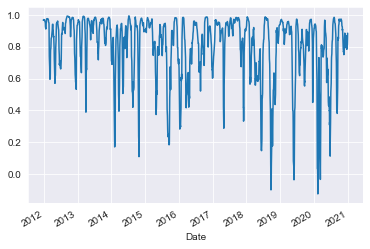

In [136]:
win_30 = df.SLV.rolling(30).corr(df.GLD).dropna()
win_30.plot()

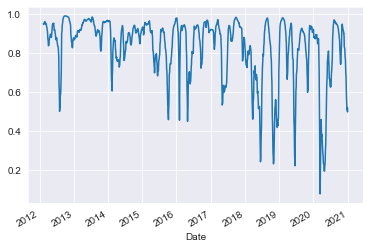

In [137]:
win_60 = df.SLV.rolling(60).corr(df.GLD).dropna()
win_60.plot()


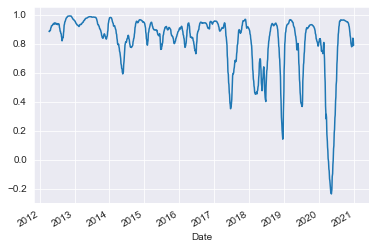

In [138]:
win_100 = df.SLV.rolling(100).corr(df.GLD).dropna()
win_100.plot()

We note that as we increase the window size, the curves become smoother and we extract a less noisy signal

In addition there are spikes in the rolling correlations indicative of a break in pattern. To observe 

We can obtain the DCC model via GARCH and cholesky decomposition at each forecast to derive the conditional correlation.

Extracting the step-wise covariance matrix and solving for the correlations at each time step.
We save these and plot the values along with density plots.


In [139]:
# we need to calculate the log-returns between our variables first
import numpy as np
import datetime as dt
from dcc import DCC

slv_l_ret = np.log(df.SLV/df.SLV.shift(1))*100
gld_l_ret = np.log(df.GLD/df.GLD.shift(1))*100
uso_l_ret = np.log(df.USO/df.USO.shift(1))*100
df_l_ret = pd.DataFrame([slv_l_ret, gld_l_ret, uso_l_ret]).transpose()
df_l_ret = df_l_ret.dropna()

rt = df_l_ret[['SLV', 'GLD']]
window = 30
n_days = 1
i = DCC()
sample = rt[1000:]

series = i.conditional_corr(sample, window, n_days, 't')


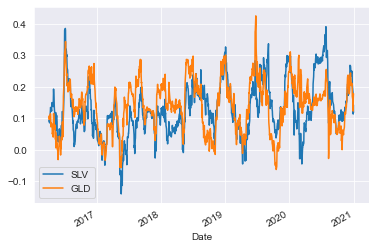

In [125]:
sc = sample.rolling(100).corr(df.GLD).dropna()
sc.plot()

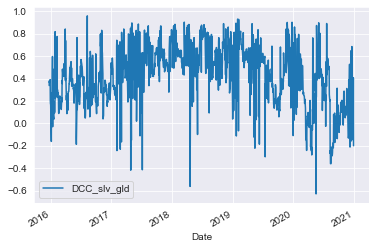

In [122]:
# attach an index for the dates on the X axis
ind = sample[window:]
s = pd.DataFrame(list(series), columns = ['DCC_slv_gld'], index = ind.index)
s.plot()

Conditionally we can observe that the relationship between GLD and SLV as a conditionally positive correlation. We note significant breaks in this correlation at the given dates.




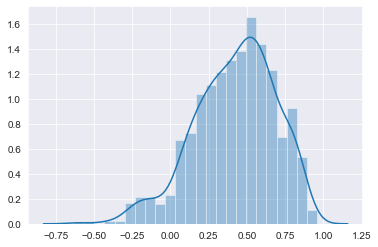

In [123]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(s)
# plotting the empirical density function of the dynamic conditional correlation model

Next we attempt to model the stochastic correlation of two correlated bronwian motions.

This endeavour is a little bit tricky and involves more steps, maths and coffee. The code for this function will be included in the file; stoch_corr.py, within it the class ModifiedOU is called for calibration and estimation of the stochastic correlation under two correlated Brownian Motions.

In short it involves fitting a transition density function to the historical correlations